In [1]:
import pandas as pd
import numpy as np
import csv
import os
import os.path
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import scipy.stats as ss
from scipy.stats import anderson
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from neuralprophet import NeuralProphet #Neuralprophet 설치
from neuralprophet import set_log_level
import warnings
import datetime
warnings.filterwarnings("ignore")
from glob import glob
import plotly.express as px
from torch.utils.tensorboard import SummaryWriter

In [2]:
path='C:/Users/kwonc/Desktop/산지부태양광관련자료/235720_동서발전 태양광 발전량 예측 AI 경진대회_data'

In [3]:
os.listdir(path)

['당진지역발전소 동네예보.csv',
 '당진지역발전소인근기상관측자료.csv',
 '발전량예측1.csv',
 '발전량전처리.csv',
 '발전소별 발전량(KW).csv',
 '발전소정보.csv',
 '분석결과파일',
 '울산지역발전소동네예보.csv',
 '울산지역발전소인근기상관측자료.csv']

In [6]:
site_info=pd.read_csv(path+'/'+os.listdir(path)[5])
site_info.head()

,Id,Capacity(MW),Address,설치각,입사각,위도,경도
0,당진수상태양광,1.0,충남당진시 석문면 교로길 30,30,30,37.050753,126.510299
1,당진자재창고태양광,0.7,충남당진시 석문면 교로길 30,30,30,37.050753,126.510299
2,당진태양광,1.0,충남당진시 석문면 교로길 30,30,30,37.050753,126.510299
3,울산태양광,0.5,울산광역시 남구 용잠로 623,20,20,35.477651,129.380778


Text(0.5, 1.0, '발전소별 발전용량')

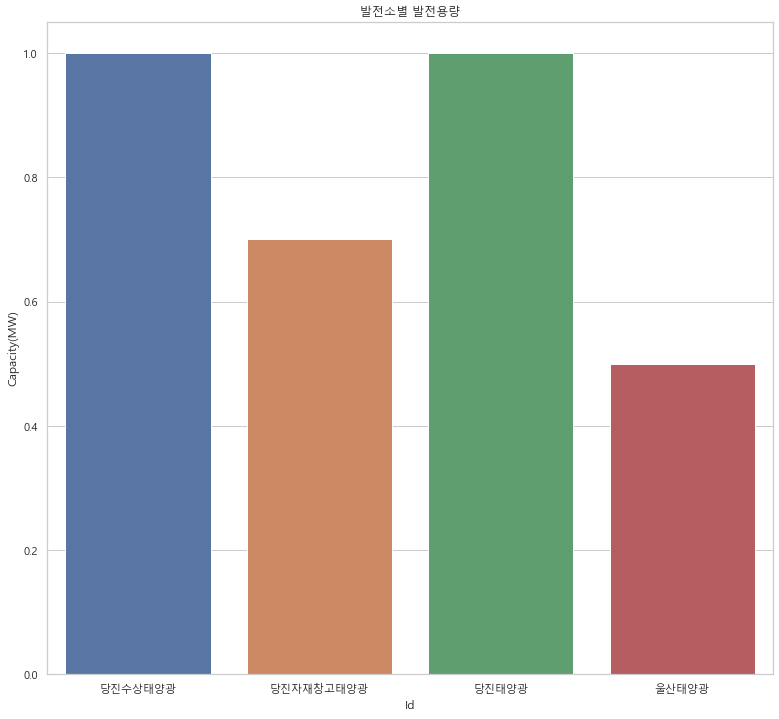

In [7]:
category=site_info['Id']
value=site_info['Capacity(MW)']
label=np.arange(len(category))
colors = sns.color_palette('Paired',len(category))
sns.set_palette('Paired')
fig=plt.figure(figsize=(13,12))
sns.set_theme(style='whitegrid')
plt.rc('font',family='Malgun Gothic')
bar_graph=sns.barplot(data=site_info,x=category,y=value,dodge=False)
plt.title('발전소별 발전용량')

In [8]:
os.listdir(path)

['당진지역발전소 동네예보.csv',
 '당진지역발전소인근기상관측자료.csv',
 '발전량예측1.csv',
 '발전량전처리.csv',
 '발전소별 발전량(KW).csv',
 '발전소정보.csv',
 '분석결과파일',
 '울산지역발전소동네예보.csv',
 '울산지역발전소인근기상관측자료.csv']

In [24]:
energy=pd.read_csv(path+'/'+os.listdir(path)[4],encoding='cp949')
energy.head(11)

,time,당진수상태양광 발전량,당진자재창고태양광 발전량,당진태양광 발전량,울산태양광 발전량
0,2018-03-01 1:00,0.0,0.0,0,0
1,2018-03-01 2:00,0.0,0.0,0,0
2,2018-03-01 3:00,0.0,0.0,0,0
3,2018-03-01 4:00,0.0,0.0,0,0
4,2018-03-01 5:00,0.0,0.0,0,0
5,2018-03-01 6:00,0.0,0.0,0,0
6,2018-03-01 7:00,0.0,0.0,0,0
7,2018-03-01 8:00,0.0,0.0,0,4
8,2018-03-01 9:00,36.0,33.0,37,35
9,2018-03-01 10:00,313.0,209.0,318,71


In [25]:
#변수개수, 행개수, 변수타입 추출하는 함수 작성
def first_EDA(data):
    변수개수=data.shape[1]
    행개수=data.shape[0]
    변수별타입=data.info()
    결측치개수=data.isnull().sum()
    print('-'*15,'열&행 개수','-'*15)
    print(f'해당 데이터의 변수 개수는{변수개수}개 입니다')
    print(f'해당 데이터 행의 개수는 {행개수}개 입니다')
    print('-'*20,'컬럼별 결측치 개수','-'*20)
    print(결측치개수)
first_EDA(energy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           25632 non-null  object 
 1   당진수상태양광 발전량    25608 non-null  float64
 2   당진자재창고태양광 발전량  25584 non-null  float64
 3   당진태양광 발전량      25632 non-null  int64  
 4   울산태양광 발전량      25632 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1001.4+ KB
--------------- 열&행 개수 ---------------
해당 데이터의 변수 개수는5개 입니다
해당 데이터 행의 개수는 25632개 입니다
-------------------- 컬럼별 결측치 개수 --------------------
time              0
당진수상태양광 발전량      24
당진자재창고태양광 발전량    48
당진태양광 발전량         0
울산태양광 발전량         0
dtype: int64


In [26]:
#결측치 있는 INDEX 추출
energy[energy['당진수상태양광 발전량'].isnull()].index

Int64Index([20352, 20353, 20354, 20355, 20356, 20357, 20358, 20359, 20360,
            20361, 20362, 20363, 20364, 20365, 20366, 20367, 20368, 20369,
            20370, 20371, 20372, 20373, 20374, 20375],
           dtype='int64')

In [27]:
#인근 발전소인 당진태양광 발전량으로 결측값 대체
energy.loc[20352:20375,'당진수상태양광 발전량']=energy.loc[20352:20375,'당진태양광 발전량']

In [28]:
energy[energy['당진자재창고태양광 발전량'].isnull()].index
energy.loc[384:431,'당진자재창고태양광 발전량']=energy.loc[384:431,'당진태양광 발전량']

In [29]:
first_EDA(energy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           25632 non-null  object 
 1   당진수상태양광 발전량    25632 non-null  float64
 2   당진자재창고태양광 발전량  25632 non-null  float64
 3   당진태양광 발전량      25632 non-null  int64  
 4   울산태양광 발전량      25632 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1001.4+ KB
--------------- 열&행 개수 ---------------
해당 데이터의 변수 개수는5개 입니다
해당 데이터 행의 개수는 25632개 입니다
-------------------- 컬럼별 결측치 개수 --------------------
time             0
당진수상태양광 발전량      0
당진자재창고태양광 발전량    0
당진태양광 발전량        0
울산태양광 발전량        0
dtype: int64


In [30]:
energy

,time,당진수상태양광 발전량,당진자재창고태양광 발전량,당진태양광 발전량,울산태양광 발전량
0,2018-03-01 1:00,0.0,0.0,0,0
1,2018-03-01 2:00,0.0,0.0,0,0
2,2018-03-01 3:00,0.0,0.0,0,0
3,2018-03-01 4:00,0.0,0.0,0,0
4,2018-03-01 5:00,0.0,0.0,0,0
...,...,...,...,...,...
25627,2021-01-31 20:00,0.0,0.0,0,0
25628,2021-01-31 21:00,0.0,0.0,0,0
25629,2021-01-31 22:00,0.0,0.0,0,0
25630,2021-01-31 23:00,0.0,0.0,0,0


In [31]:
def con_time(data):
    new=pd.DataFrame()
    for i in range(len(data)):
        if (len(data['time'][i])==15) | (len(data['time'][i])==16):
            data1=pd.DataFrame(data.loc[i]).transpose()
            new=new.append(data.loc[i])          
        else:
            pass
    return(new)

energy_new=con_time(energy)

In [32]:
first_EDA(energy_new)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24564 entries, 0 to 25630
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           24564 non-null  object 
 1   당진수상태양광 발전량    24564 non-null  float64
 2   당진자재창고태양광 발전량  24564 non-null  float64
 3   당진태양광 발전량      24564 non-null  float64
 4   울산태양광 발전량      24564 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.1+ MB
--------------- 열&행 개수 ---------------
해당 데이터의 변수 개수는5개 입니다
해당 데이터 행의 개수는 24564개 입니다
-------------------- 컬럼별 결측치 개수 --------------------
time             0
당진수상태양광 발전량      0
당진자재창고태양광 발전량    0
당진태양광 발전량        0
울산태양광 발전량        0
dtype: int64


In [33]:
pd.options.plotting.backend = 'plotly'
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [34]:
#날짜 변수 분리

energy_new['date'] = energy_new['time'].apply(lambda x: x.split()[0])
energy_new['time'] = energy_new['time'].apply(lambda x: x.split()[1])
energy_new['time'] = energy_new['time'].str.rjust(8,'0')

In [35]:
energy_new

,time,당진수상태양광 발전량,당진자재창고태양광 발전량,당진태양광 발전량,울산태양광 발전량,date
0,00001:00,0.0,0.0,0.0,0.0,2018-03-01
1,00002:00,0.0,0.0,0.0,0.0,2018-03-01
2,00003:00,0.0,0.0,0.0,0.0,2018-03-01
3,00004:00,0.0,0.0,0.0,0.0,2018-03-01
4,00005:00,0.0,0.0,0.0,0.0,2018-03-01
...,...,...,...,...,...,...
25626,00019:00,0.0,0.0,0.0,0.0,2021-01-31
25627,00020:00,0.0,0.0,0.0,0.0,2021-01-31
25628,00021:00,0.0,0.0,0.0,0.0,2021-01-31
25629,00022:00,0.0,0.0,0.0,0.0,2021-01-31


In [36]:
energy_new['time'] = energy_new['date'] + ' ' + energy_new['time']
energy_new['time'] = pd.to_datetime(energy_new['time'])
energy_new.loc[energy_new['time'].dt.hour==0,'time'] += timedelta(days=1)

In [37]:
energy_new.loc[energy_new['time'].dt.hour==0,'time'] += timedelta(days=1)
energy_new

,time,당진수상태양광 발전량,당진자재창고태양광 발전량,당진태양광 발전량,울산태양광 발전량,date
0,2018-03-01 01:00:00,0.0,0.0,0.0,0.0,2018-03-01
1,2018-03-01 02:00:00,0.0,0.0,0.0,0.0,2018-03-01
2,2018-03-01 03:00:00,0.0,0.0,0.0,0.0,2018-03-01
3,2018-03-01 04:00:00,0.0,0.0,0.0,0.0,2018-03-01
4,2018-03-01 05:00:00,0.0,0.0,0.0,0.0,2018-03-01
...,...,...,...,...,...,...
25626,2021-01-31 19:00:00,0.0,0.0,0.0,0.0,2021-01-31
25627,2021-01-31 20:00:00,0.0,0.0,0.0,0.0,2021-01-31
25628,2021-01-31 21:00:00,0.0,0.0,0.0,0.0,2021-01-31
25629,2021-01-31 22:00:00,0.0,0.0,0.0,0.0,2021-01-31


In [38]:
sample_7=energy_new[:23*7]
sample_7.head(23)

,time,당진수상태양광 발전량,당진자재창고태양광 발전량,당진태양광 발전량,울산태양광 발전량,date
0,2018-03-01 01:00:00,0.0,0.0,0.0,0.0,2018-03-01
1,2018-03-01 02:00:00,0.0,0.0,0.0,0.0,2018-03-01
2,2018-03-01 03:00:00,0.0,0.0,0.0,0.0,2018-03-01
3,2018-03-01 04:00:00,0.0,0.0,0.0,0.0,2018-03-01
4,2018-03-01 05:00:00,0.0,0.0,0.0,0.0,2018-03-01
5,2018-03-01 06:00:00,0.0,0.0,0.0,0.0,2018-03-01
6,2018-03-01 07:00:00,0.0,0.0,0.0,0.0,2018-03-01
7,2018-03-01 08:00:00,0.0,0.0,0.0,4.0,2018-03-01
8,2018-03-01 09:00:00,36.0,33.0,37.0,35.0,2018-03-01
9,2018-03-01 10:00:00,313.0,209.0,318.0,71.0,2018-03-01


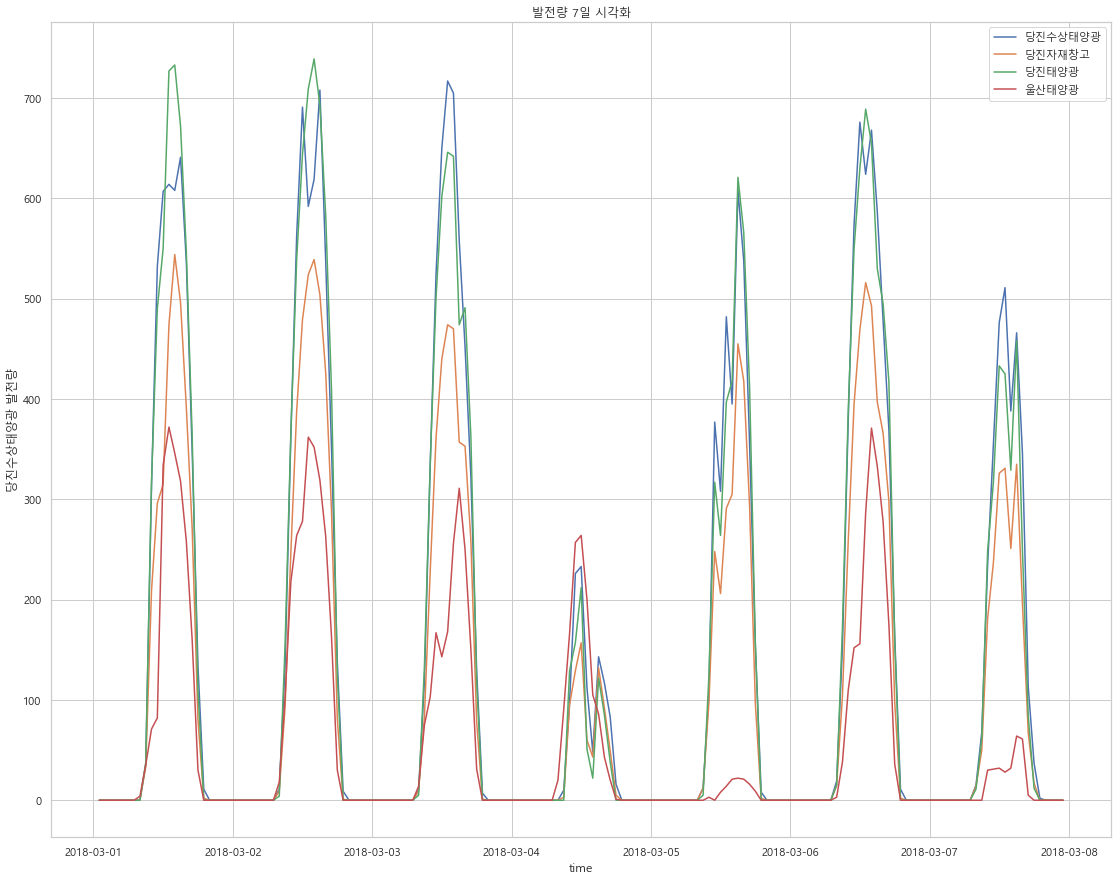

In [39]:
fig=plt.figure(figsize=(19,15))
plt.title('발전량 7일 시각화')
sns.lineplot(data=sample_7,x='time', y='당진수상태양광 발전량')
sns.lineplot(data=sample_7,x='time', y='당진자재창고태양광 발전량')
sns.lineplot(data=sample_7,x='time', y='당진태양광 발전량')
sns.lineplot(data=sample_7,x='time', y='울산태양광 발전량')
plt.legend(labels=['당진수상태양광','당진자재창고','당진태양광','울산태양광'])

In [40]:
# 당진 수상태양광 발전량 분석 진행

In [41]:
sample1=energy_new[['time','당진수상태양광 발전량']]

In [42]:
#Train Test Split

cutoff='2020-11-01'
train_df = sample1[sample1['time']<=cutoff]
test_df = sample1[sample1['time']>cutoff]

In [43]:
print(len(train_df))
print(len(test_df))

22448
2116


In [44]:
train_df

,time,당진수상태양광 발전량
0,2018-03-01 01:00:00,0.0
1,2018-03-01 02:00:00,0.0
2,2018-03-01 03:00:00,0.0
3,2018-03-01 04:00:00,0.0
4,2018-03-01 05:00:00,0.0
...,...,...
23418,2020-10-31 19:00:00,0.0
23419,2020-10-31 20:00:00,0.0
23420,2020-10-31 21:00:00,0.0
23421,2020-10-31 22:00:00,0.0


In [54]:
# Neural Prophet의 분석에 맞게 새로운 데이터 프레임 생성
df=pd.DataFrame()
df['ds']=train_df['time']
df['y']=train_df['당진수상태양광 발전량']
df

,ds,y
0,2018-03-01 01:00:00,0.0
1,2018-03-01 02:00:00,0.0
2,2018-03-01 03:00:00,0.0
3,2018-03-01 04:00:00,0.0
4,2018-03-01 05:00:00,0.0
...,...,...
23418,2020-10-31 19:00:00,0.0
23419,2020-10-31 20:00:00,0.0
23420,2020-10-31 21:00:00,0.0
23421,2020-10-31 22:00:00,0.0


In [55]:
2116/23

92.0

In [56]:
np.mean(test_df['당진수상태양광 발전량'])

86.87948960302458

In [57]:
#모델 설정
model=NeuralProphet(n_forecasts=138,learning_rate=0.001,batch_size=32,epochs=200,
                    yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='off') #기본적으로 태양광 발전량은 추세라기보다는 주간, 일간계절성이 있는것으로 판단하여 추세에 대한 설정은 하지 않았습니다.
loss=model.fit(df,freq='H') #손실값
df_pred=model.make_future_dataframe(df,periods=2116)
predict=model.predict(df_pred)

WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 95.652% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
Epoch[200/200]: 100%|████████████| 200/200 [03:05<00:00,  1.08it/s, SmoothL1Loss=0.0165, MAE=68.6, RMSE=104, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 95.652% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.953% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency 

In [1]:
loss #epoch당 MAE,RMSE 값 확인 가능
#MAE=평균 절대오차로 그 값이 낮을 수록 좋음 현재 모델에서는 점점 낮아지고있지만 정규화시킨 독립변인을 추가하여 모델에 사용한다면 성능더 좋아질듯
#RMSE 평균 제곱값 오차로 예측값과 실제값의 차이의 제곱임.

In [ ]:
print("==============Evaluate Result============")
print(f'MAE: {loss["MAE"][199]}')
print(f'RMSE: {loss["RMSE"][199]}')

In [ ]:
#예측값
submission=predict
submission.loc[submission['yhat1']<0,'yhat1']=0
submission=submission[['ds','yhat1']]

In [2]:
submission

In [ ]:
train_pred=model.predict(df)
train_pred

In [ ]:
fig1 = model.plot(train_pred[-30*24*6:])
fig2 = model.plot(train_pred[-7*24*6:])
#comp = m.plot_components(train_pred)
param = model.plot_parameters()

In [ ]:
a=list(range(0,2116,24))

In [38]:
submission=submission.drop(a,axis=0)
len(submission)

2027

In [39]:
submission

,ds,yhat1
1,2020-11-01 01:00:00,0.0
2,2020-11-01 02:00:00,0.0
3,2020-11-01 03:00:00,0.0
4,2020-11-01 04:00:00,0.0
5,2020-11-01 05:00:00,0.0
...,...,...
2110,2021-01-27 22:00:00,0.0
2111,2021-01-27 23:00:00,0.0
2113,2021-01-28 01:00:00,0.0
2114,2021-01-28 02:00:00,0.0


In [40]:
# define tensorboard logger
log_dir='./산자부/NeuralProphet'
writer = SummaryWriter('./산자부/NeuralProphet')
log_interval = 200

def board_visual(dataset):
    for i in range(len(loss)):
        writer.add_scalar('Neural Prophet MAE',dataset['MAE'][i],i)
        writer.add_scalar('Neural Prophet RMSE',dataset['RMSE'][i],i)
    print('-'*10,'Tensor시각화 종료','-'*10)   

In [41]:
board_visual(loss)

---------- Tensor시각화 종료 ----------


In [42]:
%load_ext tensorboard
%tensorboard --logdir='./산자부/NeuralProphet' --port 6015

In [43]:
##미래 예측값
#예측값
submission=predict
submission.loc[submission['yhat1']<0,'yhat1']=0
submission=submission[['ds','yhat1']]

In [44]:
submission

,ds,yhat1
0,2020-11-01 00:00:00,0.0
1,2020-11-01 01:00:00,0.0
2,2020-11-01 02:00:00,0.0
3,2020-11-01 03:00:00,0.0
4,2020-11-01 04:00:00,0.0
...,...,...
2111,2021-01-27 23:00:00,0.0
2112,2021-01-28 00:00:00,0.0
2113,2021-01-28 01:00:00,0.0
2114,2021-01-28 02:00:00,0.0


In [45]:
test_df

,time,당진수상태양광 발전량
23424,2020-11-01 01:00:00,0.0
23425,2020-11-01 02:00:00,0.0
23426,2020-11-01 03:00:00,0.0
23427,2020-11-01 04:00:00,0.0
23428,2020-11-01 05:00:00,0.0
...,...,...
25626,2021-01-31 19:00:00,0.0
25627,2021-01-31 20:00:00,0.0
25628,2021-01-31 21:00:00,0.0
25629,2021-01-31 22:00:00,0.0


In [48]:
a=list(range(0,2116,24))
submission=submission.drop(a,axis=0)
len(submission)

2027

In [55]:
submission1=submission[0:23*7]

In [57]:
test_Df=test_df[0:2027]

In [59]:
test_DF=test_Df[0:23*7]

In [60]:
test_DF

,time,당진수상태양광 발전량
23424,2020-11-01 01:00:00,0.0
23425,2020-11-01 02:00:00,0.0
23426,2020-11-01 03:00:00,0.0
23427,2020-11-01 04:00:00,0.0
23428,2020-11-01 05:00:00,0.0
...,...,...
23586,2020-11-07 19:00:00,0.0
23587,2020-11-07 20:00:00,0.0
23588,2020-11-07 21:00:00,0.0
23589,2020-11-07 22:00:00,0.0


In [54]:
### 예측값 vs test 발전량

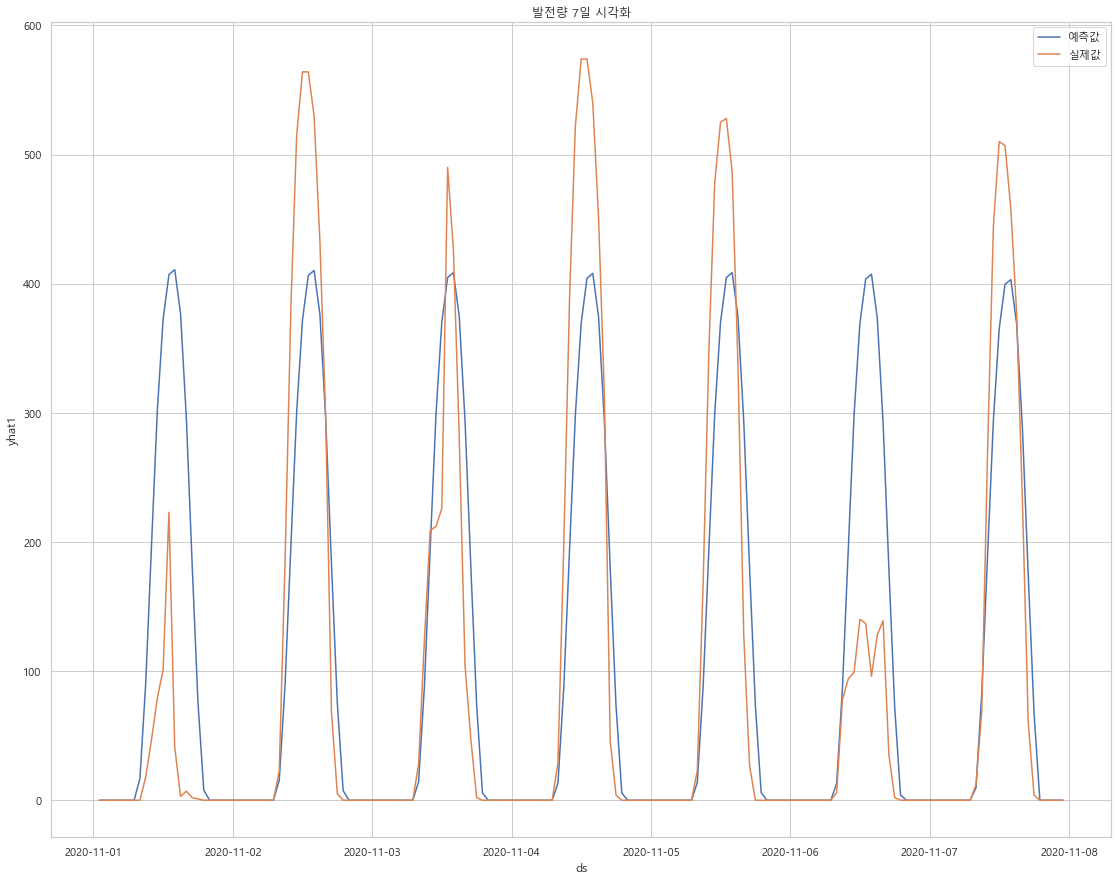

In [62]:
fig=plt.figure(figsize=(19,15))
plt.title('발전량 7일 시각화')
sns.lineplot(data=submission1,x='ds', y='yhat1')
sns.lineplot(data=test_DF,x='time', y='당진수상태양광 발전량')
plt.legend(labels=['예측값','실제값'])